In [49]:
from hydra.core.global_hydra import GlobalHydra
from hydra import initialize_config_dir, compose
import pandas as pd
from pathlib import Path
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import numpy as np
import json
import random

# Initialize Hydra with the config path
GlobalHydra.instance().clear()
initialize_config_dir(config_dir="/home/ta-tldr/Project/tldr/config/", version_base=None)
cfg = compose(config_name="TrafficQA.yaml")
dataset_root = cfg.TrafficQA.dataset_root
video_root = dataset_root + "raw_videos/"

# per_token = True
per_token = False

# load csv file
df_info = pd.read_csv(Path(dataset_root, "csv", "response_mutual_info_text_task_new4.csv"), delimiter="|")
df_comp = pd.read_csv(Path(dataset_root, "csv", "response_mutual_info_video_text_new4.csv"), delimiter="|")
CoT_df_info = pd.read_csv(Path(dataset_root, "csv", "CoT_mutual_info_text_task.csv"), delimiter="|")
CoT_df_comp = pd.read_csv(Path(dataset_root, "csv", "CoT_mutual_info_video_text.csv"), delimiter="|")

print(df_info.head())
print(df_comp.head())

   video_id  record_id               vid_filename               q_type  \
0      2058       1283  b_1Gb411G7XZ_clip_004.mp4  Basic Understanding   
1      2058      39332  b_1Gb411G7XZ_clip_004.mp4  Basic Understanding   
2      2058      27957  b_1Gb411G7XZ_clip_004.mp4  Basic Understanding   
3      2058      55799  b_1Gb411G7XZ_clip_004.mp4  Basic Understanding   
4      2058       1283  b_1Gb411G7XZ_clip_004.mp4  Basic Understanding   

             group predicted_answer_text predicted_answer correct_answer  \
0  temperature_0.0                     A                A              A   
1  temperature_0.0                     C                C              C   
2  temperature_0.0                     B                B              B   
3  temperature_0.0                     A                A              A   
4  temperature_0.5                     A                A              A   

   informativeness_score  logprob_text   logprob  rank_text  rank  
0               2.354471     -

In [50]:
# Load the sampled stimulus data
sampled_stimulus_df = pd.read_csv("/home/ta-tldr/Project/tldr/user_study/trafficqa/data/sampled_stimulus_100.csv")

# Filter rows in filtered_df_info to keep only those with video_id and record_id present in sampled_stimulus_df
CoT_df_info = CoT_df_info.merge(sampled_stimulus_df[['video_id', 'record_id']], on=['video_id', 'record_id'], how='inner')
CoT_df_comp = CoT_df_comp.merge(sampled_stimulus_df[['video_id', 'record_id']], on=['video_id', 'record_id'], how='inner')

In [51]:
# Filter out rows with -10 in logprob_text or logprob
def filter_logprob(df_info, threshold=-10):
    return set(df_info[(df_info['logprob_text'] > threshold) & (df_info['logprob'] > threshold)]['record_id'])

# Apply the function to each dataframe
filtered_record_ids = (filter_logprob(df_info) & filter_logprob(CoT_df_info))
df_info_filtered = df_info[df_info['record_id'].isin(filtered_record_ids)]
CoT_info_filtered = CoT_df_info[CoT_df_info['record_id'].isin(filtered_record_ids)]

def calculate_tldr_scores(df_info):
    log_info_scores = []
    info_ranks = []
    for record_id in filtered_record_ids:
        row = df_info[df_info['record_id'] == record_id]
        info_score = row['informativeness_score'].values[0]
        log_info_scores.append(info_score)
        info_ranks.append(row["logprob_text"].values[0] - row["logprob"].values[0])
    return log_info_scores, info_ranks

log_info_scores, info_ranks = calculate_tldr_scores(df_info)
CoT_log_info_scores, CoT_info_ranks = calculate_tldr_scores(CoT_df_info)

# print the min and max rows (video_id) of informativeness scores
print("min informativeness: ", df_info_filtered[df_info_filtered['informativeness_score'] == min(log_info_scores)]['record_id'].values[0])
print("max informativeness: ", df_info_filtered[df_info_filtered['informativeness_score'] == max(log_info_scores)]['record_id'].values[0])
print("min CoT informativeness: ", CoT_info_filtered[CoT_info_filtered['informativeness_score'] == min(CoT_log_info_scores)]['record_id'].values[0])
print("max CoT informativeness: ", CoT_info_filtered[CoT_info_filtered['informativeness_score'] == max(CoT_log_info_scores)]['record_id'].values[0])

min informativeness:  35201
max informativeness:  49565
min CoT informativeness:  44306
max CoT informativeness:  61289


In [52]:
def initialize_dataframe():
    columns = ['video_id', 'group', 'predicted_word_video', 'predicted_word', 'orig_word', 'complexity_score', 'rank_video', 'rank']
    dtypes = {
        'video_id': 'int', 
        'group': 'object',
        'predicted_word_video': 'object',
        'predicted_word': 'object',        
        'orig_word': 'object',             
        'complexity_score': 'float', 
        'rank_video': 'object',            
        'rank': 'object'                   
    }
    return pd.DataFrame(columns=columns).astype(dtypes)

def process_data(df_info_filtered, df_comp):
    df_comp_total = initialize_dataframe()
    log_comp_scores = []
    comp_ranks = []
    max_id, min_id = None, None
    max_diff, min_diff = -100, 100
    num_tokens = []
    # Filter out rows with -10 in logprob_video or logprob
    for video_id in df_info_filtered['video_id'].unique():
        for group in df_comp['group'].unique():
            row = df_comp[(df_comp['video_id'] == video_id) & (df_comp['group'] == group)]
            if per_token:
                diff_count = len(row)
            else:
                diff_count = 1  # Placeholder value
            diff = row['diff'].sum()
            if diff == 0:
                print(f"Diff is 0 for video_id: {video_id}, group: {group}. This might be due to no video.")
                comp_ranks.append(0)
                num_tokens.append(1)
            else:
                log_comp_scores.append(diff / diff_count)
                comp_ranks.append(row['logprob_video'].values[0] - row['logprob'].values[0])
                num_tokens.append(diff_count)
                
            if diff > max_diff:
                max_diff = diff
                max_id = video_id
            if diff < min_diff:
                min_diff = diff
                min_id = video_id
            
            new_row = pd.DataFrame({
                'video_id': [video_id], 
                'group': [group],
                'predicted_word_video': [row['predicted_word_video'].values], 
                'predicted_word': [row['predicted_word'].values], 
                'orig_word': [row['orig_word'].values], 
                'complexity_score': [diff / diff_count], 
                'rank_video': [row['rank_video'].values], 
                'rank': [row['rank'].values]
            })
            df_comp_total = pd.concat([df_comp_total, new_row], ignore_index=True)
    
    return df_comp_total, log_comp_scores, comp_ranks, max_id, min_id, num_tokens


# Process data
df_comp_total, log_comp_scores, comp_ranks, max_id, min_id, num_tokens = process_data(df_info_filtered, df_comp)
CoT_df_comp_total, CoT_log_comp_scores, CoT_comp_ranks, CoT_max_id, CoT_min_id, CoT_num_tokens = process_data(df_info_filtered, CoT_df_comp)

print(f"Max complexity id: {max_id}, Min complexity id: {min_id}")
print(f"Max CoT complexity id: {CoT_max_id}, Min CoT complexity id: {CoT_min_id}")
print(f"Avg num of tokens: {sum(num_tokens) / len(num_tokens)}")
df_comp_total.head()


Max complexity id: 22501, Min complexity id: 9670
Max CoT complexity id: 4013, Min CoT complexity id: 9670
Avg num of tokens: 1.0


,video_id,group,predicted_word_video,predicted_word,orig_word,complexity_score,rank_video,rank
0,2058,temperature_0.0,"[urban, white, ahead, smooth, immediate, sign,...","[urban, white, ahead, smooth, immediate, sign,...","[urban, white, ahead, smoothly, immediate, sig...",5.919239,"[2, 3, 1, 1, -1, 1, 1, 1, -1, 1, 3, 1]","[3, 4, 1, 1, -1, 1, 1, 1, -1, 3, 4, 1]"
1,2058,temperature_0.5,"[moving, white, w, drivers, appear, mark, cond...","[moving, white, w, drivers, appear, mark, cond...","[moving, white, wet, drivers, appear, markings...",-2.078914,"[1, 1, 1, 1, 2, 8, 3, 13, 1, 2, 1]","[1, 1, 1, 2, 2, 11, 3, 17, 1, 2, 1]"
2,2058,temperature_1.0,"[navigate, w, maint, sit, smooth, flow, clear,...","[navigate, w, maint, sit, smooth, flow, clear,...","[navigate, wet, maintaining, situation, smooth...",8.858695,"[1, 5, 2, 1, 2, 1, 4, 5, 1]","[2, 10, 4, 1, 3, 1, 5, 7, 1]"
3,2058,temperature_1.25,"[navigate, cal, clear, mark, seen, sed, white,...","[navigate, cal, clear, mark, seen, sed, white,...","[navigate, calm, clear, markings, seen, sedan,...",1.952224,"[1, 1, 3, 7, 3, 2, 1, 1, 9, 1, 1]","[1, 1, 3, 9, 12, 2, 2, 1, 9, 1, 1]"
4,2058,temperature_1.5,"[drivers, navigate, cal, drivers, captures, st...","[drivers, navigate, cal, drivers, captures, st...","[drivers, navigate, calm, drivers, captures, s...",4.891375,"[-1, 1, 6, -1, -1, -1, 6]","[-1, 1, 4, -1, -1, -1, -1]"


In [53]:
# Add a 'group' column to each DataFrame before concatenation
merged_info_df = df_info_filtered.copy().drop(columns=["predicted_answer_text", "predicted_answer"])

# Sort the merged DataFrame by 'video_id'
merged_info_df = merged_info_df.sort_values(by=['record_id', 'group'])

# print(f"merged_info_df shape: {merged_info_df.shape}")
# print(merged_info_df.head())

# Create a new DataFrame with selected columns
merge_record_info_df = pd.DataFrame({
    'video_id': pd.Series(dtype='int'),
    'group': pd.Series(dtype='object'),
    'max_informativeness_score': pd.Series(dtype='float64'),
    'min_informativeness_score': pd.Series(dtype='float64'),
    'informativeness_score': pd.Series(dtype='float64')
})

cnt = 0
for video_id in merged_info_df['video_id'].unique():
    for group in merged_info_df['group'].unique():
        row = merged_info_df[(merged_info_df['video_id'] == video_id) & (merged_info_df['group'] == group)]
        if not row.empty:
            merge_record_info_df.at[cnt, 'video_id'] = int(video_id)
            merge_record_info_df.at[cnt, 'group'] = group
            merge_record_info_df.at[cnt, 'max_informativeness_score'] = max(row['informativeness_score'].values)
            merge_record_info_df.at[cnt, 'min_informativeness_score'] = min(row['informativeness_score'].values)
            merge_record_info_df.at[cnt, 'informativeness_score'] = sum(row['informativeness_score'].values) / len(row['informativeness_score'].values)
            cnt += 1

merge_record_info_df = merge_record_info_df.sort_values(by=['video_id', 'group'])
merge_record_info_df['video_id'] = merge_record_info_df['video_id'].astype(int)
print(f"new_info_df shape: {merge_record_info_df.shape}\n")
merge_record_info_df.head()

new_info_df shape: (500, 5)



,video_id,group,max_informativeness_score,min_informativeness_score,informativeness_score
45,2058,temperature_0.0,2.354471,0.000862,1.067529
46,2058,temperature_0.5,2.334795,-1.973457,0.310861
47,2058,temperature_1.0,2.327663,-1.644198,0.601605
48,2058,temperature_1.25,2.284516,0.000828,1.047650
49,2058,temperature_1.5,2.313587,0.000882,0.741247


In [54]:
# then concatenate as before
merged_complexity_df = df_comp_total.sort_values(by=['video_id', 'group'])
merged_complexity_df.drop(columns=['predicted_word_video', 'predicted_word', 'orig_word', 'rank_video', 'rank'], inplace=True)
print(f"merged_complexity_df shape: {merged_complexity_df.shape}")
print(merged_complexity_df.head())

merged_complexity_df shape: (500, 3)
   video_id             group  complexity_score
0      2058   temperature_0.0          5.919239
1      2058   temperature_0.5         -2.078914
2      2058   temperature_1.0          8.858695
3      2058  temperature_1.25          1.952224
4      2058   temperature_1.5          4.891375


In [55]:
# merge the rows of the two dataframes with the same video_id and group
ib_df = pd.merge(merged_complexity_df, merge_record_info_df, on=['video_id', 'group'], how='inner')
ib_df = ib_df.sort_values(['video_id', 'group'], ascending=True)

# # create a new column for the informativeness score difference for each beta
# alpha_betas = [(1, 0), (-1, 0), (0, 1)]
# alpha_betas += [(-0.02, 1), (-0.05, 1), (-0.1, 1), (-0.3, 1)]
# alpha_betas += [(0.02, 1), (0.05, 1), (0.1, 1), (0.3, 1)]

parameter_search_type = "convex_combination"
num_steps = 21
if parameter_search_type == "convex_combination":
    # Convex Combination Grid
    alpha_betas = [(round(a, 3), round(1 - a, 3)) for a in np.linspace(0, 1, num_steps)]
elif parameter_search_type == "unit_norm":
    # Unit Norm Grid 
    angles = np.linspace(0, np.pi/2, num_steps)
    alpha_betas = [(round(np.cos(t), 3), round(np.sin(t), 3)) for t in angles]
print(alpha_betas)

max_ib_dfs = []
max_ib_labels = []
for idx, ab in enumerate(alpha_betas):
    a, b = ab
    max_ib_labels.append(f'Max IB ($\\alpha,\\beta=({a},{b})$)')
    ib_df[f'ib_score_beta_{ab}'] = a * ib_df['complexity_score'] + b * ib_df['informativeness_score']
    # ascending=False to get the max score
    max_ib_dfs.append(ib_df.sort_values(f'ib_score_beta_{ab}', ascending=False).drop_duplicates('video_id').reset_index(drop=True))
    ib_df.drop(columns=[f'ib_score_beta_{ab}'], inplace=True)
# print(max_ib_dfs[-1].shape)
# print(max_ib_dfs[-1].head())

# randomly sample ib scores
np.random.seed(42)
ib_df["random_score"] = np.random.randint(0, 1000, len(ib_df))
# ascending=False to get the max score
max_ib_dfs.append(ib_df.sort_values('random_score', ascending=False).drop_duplicates('video_id').reset_index(drop=True))
ib_df.drop(columns=['random_score'], inplace=True)
# print(max_ib_dfs[-1].shape)
# print(max_ib_dfs[-1].head())

[(0.0, 1.0), (0.05, 0.95), (0.1, 0.9), (0.15, 0.85), (0.2, 0.8), (0.25, 0.75), (0.3, 0.7), (0.35, 0.65), (0.4, 0.6), (0.45, 0.55), (0.5, 0.5), (0.55, 0.45), (0.6, 0.4), (0.65, 0.35), (0.7, 0.3), (0.75, 0.25), (0.8, 0.2), (0.85, 0.15), (0.9, 0.1), (0.95, 0.05), (1.0, 0.0)]


In [56]:
import shutil
import seaborn as sns

def set_plot_properties(
    font_size: float = 20,
    legend_font_size: float = 14,
    xtick_label_size: float = 14,
    ytick_label_size: float = 14,
    markersize: float = 10,
    usetex: bool = True,
    autolayout=True,
) -> None:
    """Sets plot properties.

    :param font_size: font size
    :param legend_font_size: legend font size
    :param xtick_label_size: xtick label size
    :param ytick_label_size: ytick label size
    :param markersize: marker size
    :param usetex: use tex
    :return: None.
    """
    sns.set_color_codes()
    sns.set()

    if shutil.which("latex"):
        plt.rc("text", usetex=usetex)
    else:
        plt.rc("text", usetex=False)
    font = {"family": "normal", "weight": "bold", "size": font_size}
    plt.rc("font", **font)
    plt.rcParams["text.latex.preamble"] = r"\boldmath"

    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams["font.weight"] = "bold"

    params = {
        "legend.fontsize": legend_font_size,
        "axes.labelsize": font_size,
        "axes.titlesize": font_size,
        "xtick.labelsize": xtick_label_size,
        "ytick.labelsize": ytick_label_size,
        "lines.markersize": markersize,
        "figure.autolayout": autolayout,
    }

    plt.rcParams.update(params)

    # Use ticks style but only keep bottom and left spines
    sns.set_style("ticks")
    plt.rc('axes', edgecolor='black')
    plt.rc('axes.spines', right=False, top=False, left=True, bottom=True)

set_plot_properties(font_size=12, legend_font_size=12, xtick_label_size=12, ytick_label_size=12, markersize=10)


In [57]:
visible = {
    # 'TLDR': True,
    # 'Abstract': True,
    # 'VLM (Aware)': True,
    # 'VLM (Agnostic)': True,
    'CoT': True
}
for label in max_ib_labels:
    visible[label] = True
visible["random"] = True

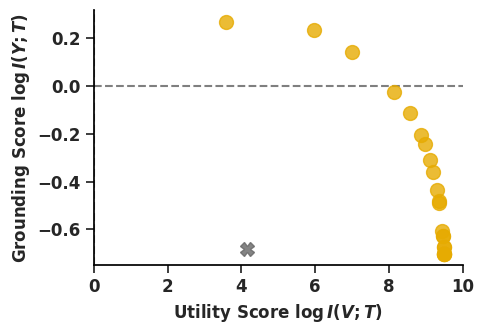

In [65]:
# Create a figure for the scatter plot only
fig = plt.figure(figsize=(5, 3.5))
scatter_ax = fig.add_subplot(111)  # Single plot taking up the entire figure

# Simple color and marker setup
colors = sns.color_palette("Dark2")
markers = ['v', 's', 'X', 'o', 'D']
opacity = 0.8

# Define data groups
data_groups = {
    # 'CoT': {
    #     'x': CoT_log_comp_scores,
    #     'y': CoT_log_info_scores,
    #     'color': colors[1],
    #     'marker': markers[4],
    #     'alpha': opacity
    # },
    'random': {
        'x': max_ib_dfs[-1]['complexity_score'],
        'y': max_ib_dfs[-1]['informativeness_score'],
        'color': colors[7],
        'marker': markers[2],
        'alpha': opacity
    }
}

# Add max_ib data
for idx, label in enumerate(max_ib_labels):
    data_groups[label] = {
        'x': max_ib_dfs[idx]['complexity_score'],
        'y': max_ib_dfs[idx]['informativeness_score'],
        'color': colors[5],
        'marker': markers[3],
        'alpha': opacity
    }

# Set display labels
ib_legend = False
for label, group_data in data_groups.items():
    if label == 'CoT':
        label_latex = "VLM (CoT)"
    elif label == 'VLM (Agnostic)':
        label_latex = 'VLM (Agnostic)'
    elif label == 'random':
        label_latex = 'Naive VLM'
    elif label in ['TLDR', 'Abstract']:
        label_latex = label + " (OpenReview)"
    elif "Max IB" in label and not ib_legend:
        label_latex = "VIBE (ours)"
        ib_legend = True
    else:
        label_latex = ""
    
    # Error bars with standard deviation
    scatter_ax.errorbar(
        np.mean(group_data['x']), np.mean(group_data['y']),
        # xerr=np.std(group_data['x']), yerr=np.std(group_data['y']),
        fmt=group_data['marker'], color=group_data['color'], 
        elinewidth=1.5, capsize=8, alpha=group_data['alpha'], label=label_latex,
        markersize=10  # Increased marker size
    ) if visible[label] else None

# Add x=0 and y=0 lines
scatter_ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
scatter_ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
scatter_ax.set_xlabel('Utility Score $\log I(V;T)$ ') # negative complexity score
scatter_ax.set_ylabel('Grounding Score $\log I(Y;T)$ ') # informativeness score
scatter_ax.set_xlim(0, 10)
# scatter_ax.set_ylim(-0.5, 2)

# Add legend
# scatter_ax.legend(frameon=False, framealpha=0.9, loc='upper center', 
#                  bbox_to_anchor=(0.5, 1.15), ncol=3, fontsize=9,
#                  columnspacing=1.0, handletextpad=0.5)

plt.tight_layout()
plt.show()

fig.savefig('traffic_ib_pareto.pdf', format='pdf', dpi=300, bbox_inches='tight')

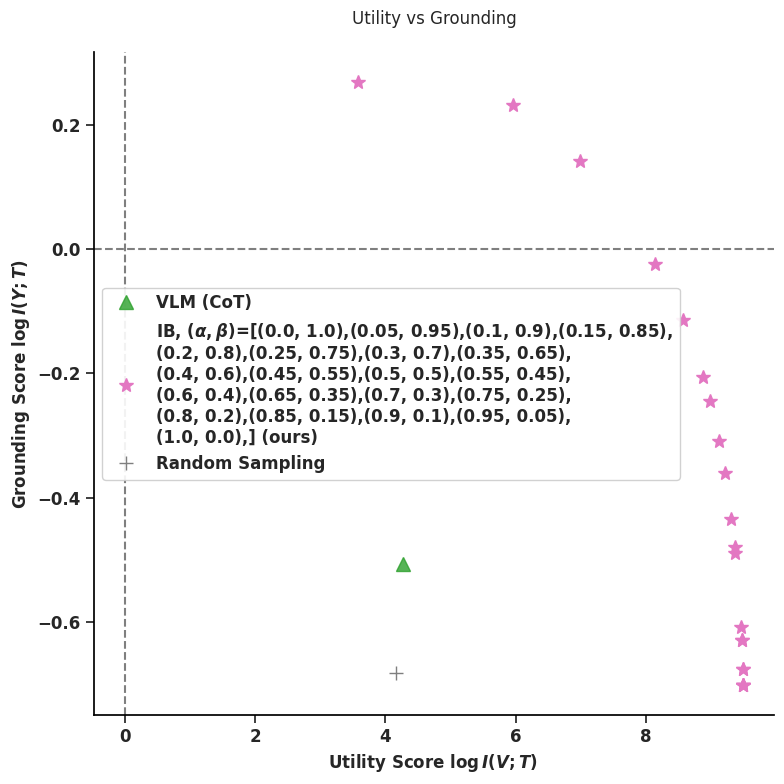

In [59]:
# Create a figure for the main scatter plot
fig, scatter_ax = plt.subplots(figsize=(8, 8))

# Create a custom color palette for better distinction
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b', '#d62728', '#e377c2', '#7f7f7f']
markers = ['o', 's', '^', 'd', 'x', 'P', '*', '+']
opacity = [0.8, 0.8, 0.8, 0.8, 1, 1, 1, 1]
data_groups = {
    'CoT': {
        'x': CoT_log_comp_scores,
        'y': CoT_log_info_scores,
        'color': colors[2],
        'marker': markers[2],
        'alpha': opacity[2]
    },
}
for idx, label in enumerate(max_ib_labels):
    data_groups[label] = {
        'x': max_ib_dfs[idx]['complexity_score'],
        'y': max_ib_dfs[idx]['informativeness_score'],
        'color': colors[6],
        'marker': markers[6],
        'alpha': opacity[6]
    }
data_groups["random"] = {
        'x': max_ib_dfs[-1]['complexity_score'],
        'y': max_ib_dfs[-1]['informativeness_score'],
        'color': colors[7],
        'marker': markers[7],
        'alpha': opacity[7]
    }

# Create scatter plots and error bars for each group
ib_legend = False
for label, group_data in data_groups.items():
    if label == 'CoT':
        label_latex = "VLM (CoT)"
    elif label == 'random':
        label_latex = "Random Sampling"
    elif "Max IB" in label and not ib_legend:
        label_latex = "IB, $(\\alpha, \\beta)$=["
        for idx, ab in enumerate(alpha_betas):
            label_latex += f"{ab},"
            if idx % 4 == 3:
                label_latex += '\n'
        label_latex += "] (ours)"
        ib_legend = True
    else:
        label_latex = ""

    # Main scatter plot with error bars
    scatter_ax.errorbar(
        np.mean(group_data['x']), np.mean(group_data['y']),
        fmt=group_data['marker'], color=group_data['color'], 
        elinewidth=1.5, capsize=8, alpha=group_data['alpha'], label=label_latex,
        markersize=10  # Increased marker size
    ) if visible[label] else None

# Add x=0 and y=0 lines
scatter_ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
scatter_ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
scatter_ax.set_xlabel('Utility Score $\log I(V;T)$ ')  # Negative complexity score
scatter_ax.set_ylabel('Grounding Score $\log I(Y;T)$ ')  # Informativeness score
scatter_ax.set_title('Utility vs Grounding', pad=20)

# Add a vertical arrow pointing upwards with text above it
scatter_ax.annotate('More\nInformative',
                    xy=(3.5, 3.75),  # Arrow tip
                    xytext=(3.5, 1.5),  # Arrow tail (lower position for upward direction)
                    arrowprops=dict(color='black', arrowstyle='-|>', lw=2),
                    fontsize=10, color='red',
                    ha='center',  # Center text horizontally
                    va='bottom')  # Ensure text is above the arrow

# Add a horizontal arrow pointing left with text above it
scatter_ax.annotate('More Grounded to Video',
                    xy=(30, 3.5),  # Arrow tip (further left)
                    xytext=(15, 3.5),  # Arrow tail (even further left)
                    arrowprops=dict(color='black', arrowstyle='-|>', lw=2),
                    fontsize=10, color='red',
                    ha='center',  # Align text to the right (places it left of the arrow)
                    va='center')  # Vertically center the text

# Add legend
scatter_ax.legend(frameon=True, framealpha=0.9, loc='best')

plt.show()

### Length vs. Informativeness

In [60]:
# load response length data
length_df = pd.read_csv(Path(dataset_root, "csv", "vlm_response_length.csv")) #.drop(columns=["response"])
CoT_length_df = pd.read_csv(Path(dataset_root, "csv", "vlm_CoT_length.csv")) #.drop(columns=["response"])
# IB filtering
length_ib_dfs = []
for idx, ab in enumerate(alpha_betas):
    length_df = pd.merge(length_df, max_ib_dfs[idx][['video_id', f'ib_score_beta_{ab}']], on='video_id', how='inner')
    length_ib_dfs.append(length_df.sort_values(f'ib_score_beta_{ab}', ascending=False).drop_duplicates('video_id').reset_index(drop=True))
    length_df.drop(columns=[f'ib_score_beta_{ab}'], inplace=True)

print(length_df.sort_values(by=['video_id', 'group']).head(10))

     video_id             group  \
400      2058   temperature_0.0   
401      2058   temperature_0.5   
402      2058   temperature_1.0   
403      2058  temperature_1.25   
404      2058   temperature_1.5   
215      2263   temperature_0.0   
216      2263   temperature_0.5   
217      2263   temperature_1.0   
218      2263  temperature_1.25   
219      2263   temperature_1.5   

                                              response  length  
400  In this video, a car accident occurs on a rain...      61  
401  In this video, a truck is seen driving on a we...      78  
402  In this video, a traffic accident occurs on a ...      84  
403  In this video, a traffic accident occurs on a ...      87  
404  In this video, while traffic is waiting at a r...      83  
215  The video shows a car accident involving a blu...      62  
216  A car was involved in an accident while drivin...      53  
217  In this video, a traffic accident occurs at an...      68  
218  In this video, a traffic

In [61]:
# save the best responses of each openreview ID according to the following criteria:
# 1. max informativeness score
# 2. max complexity score
# 3. min informativeness score
# 4. min complexity score


# Save the best responses based on the criteria
best_responses = {}

# 1. Max informativeness score
best_responses['max_informativeness'] = merged_info_df.loc[
    merged_info_df.groupby('video_id')['informativeness_score'].idxmax()
].drop(columns=['correct_answer', 'logprob_text', 'logprob', 'rank_text', 'rank'])

# 2. Max complexity score
best_responses['max_complexity'] = merged_complexity_df.loc[
    merged_complexity_df.groupby('video_id')['complexity_score'].idxmax()
]

# 3. Min informativeness score
best_responses['min_informativeness'] = merged_info_df.loc[
    merged_info_df.groupby('video_id')['informativeness_score'].idxmin()
].drop(columns=['correct_answer', 'logprob_text', 'logprob', 'rank_text', 'rank'])

# 4. Min complexity score
best_responses['min_complexity'] = merged_complexity_df.loc[
    merged_complexity_df.groupby('video_id')['complexity_score'].idxmin()
]

print("Best responses based on criteria:")
print("Max Informativeness:\n", best_responses["max_informativeness"].head())
print("Max Complexity:\n", best_responses["max_complexity"].head())
print("Min Informativeness:\n", best_responses["min_informativeness"].head())
print("Min Complexity:\n", best_responses["min_complexity"].head())

Best responses based on criteria:
Max Informativeness:
     video_id  record_id               vid_filename               q_type  \
0       2058       1283  b_1Gb411G7XZ_clip_004.mp4  Basic Understanding   
23      2263      17925  b_194411y72B_clip_001.mp4  Basic Understanding   
54      2638      42199  b_1764y1M7zr_clip_032.mp4  Basic Understanding   
70      2728      47135  b_1hE411k7re_clip_014.mp4  Basic Understanding   
90      2760      15710  b_1at411y7Eo_clip_007.mp4  Basic Understanding   

               group  informativeness_score  
0    temperature_0.0               2.354471  
23   temperature_0.0               2.932006  
54  temperature_1.25               0.875801  
70   temperature_1.0               0.727643  
90   temperature_1.0               1.046195  
Max Complexity:
     video_id             group  complexity_score
2       2058   temperature_1.0          8.858695
8       2263  temperature_1.25          6.300285
14      2638   temperature_1.5          4.724365
16  

In [62]:
# Add the parent directory to sys.path to make utils module accessible
import sys
sys.path.append(str(Path.cwd().parent.parent))
from utils.primary_area import subarea_map
OPTIONS = sorted(list(set(subarea_map.values())))

# save all the responses from best_responses
id2_responses_json = {}
for idx, row in length_df.iterrows():
    video_id = row['video_id']
    video_id = row['video_id']
    if video_id not in id2_responses_json:
        id2_responses_json[video_id] = {}
    for key, best_df in best_responses.items():
        group = best_df[best_df['video_id'] == video_id]['group'].values[0]
        id2_responses_json[video_id][key] = length_df[
            (length_df['video_id'] == video_id) & 
            (length_df['group'] == group)
        ]["response"].values[0]
    correct_option =  merged_info_df[
        merged_info_df['video_id'] == video_id
    ]["correct_answer"].values[0]
    correct_number = ord(correct_option) - ord('A')
    id2_responses_json[video_id]["correct_answer"] = OPTIONS[correct_number]
    id2_responses_json[video_id]['video_id'] = video_id

# save the json file
with open(Path(video_root, "best_responses.json"), 'w') as f:
    json.dump(id2_responses_json, f, indent=4)

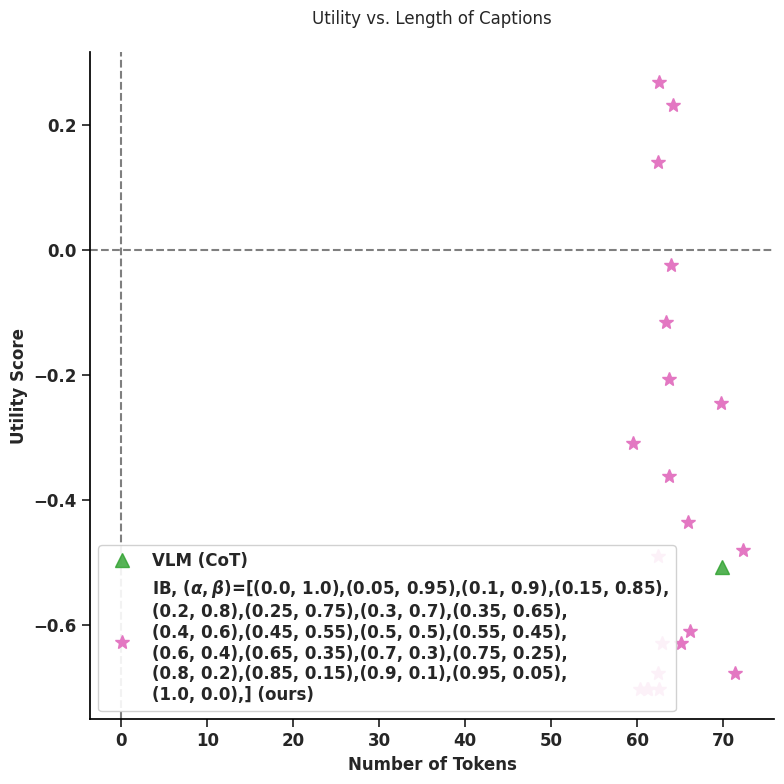

In [63]:
# Define data groups
data_groups_length = {
    'CoT': {
        'x': CoT_length_df['length'],
        'y': CoT_log_info_scores,
        'color': colors[2],
        'marker': markers[2],
        'alpha': opacity[2]
    },
}
for idx, label in enumerate(max_ib_labels):
    data_groups_length[label] = {
        'x': length_ib_dfs[idx]['length'],
        'y': max_ib_dfs[idx]['informativeness_score'],
        'color': colors[6],
        'marker': markers[6],
        'alpha': opacity[6]
    }

# Create a grid layout without space for histograms
fig, scatter_ax = plt.subplots(figsize=(8, 8))

ib_legend = False
for label, group_data in data_groups_length.items():
    if label == 'CoT':
        label_latex = "VLM (CoT)"
    elif label in ['VLM (Agnostic)', 'VLM (Aware)']:
        label_latex = label
    elif label in ['TLDR', 'Abstract']:
        label_latex = label + " (OpenReview)"
    elif "Max IB" in label and not ib_legend:
        label_latex = "IB, $(\\alpha, \\beta)$=["
        for idx, ab in enumerate(alpha_betas):
            label_latex += f"{ab},"
            if idx % 4 == 3:
                label_latex += '\n'
        label_latex += "] (ours)"
        ib_legend = True
    else:
        label_latex = ""

    # Main scatter plot
    scatter_ax.errorbar(
        np.mean(group_data['x']), np.mean(group_data['y']),
        fmt=group_data['marker'], color=group_data['color'],
        elinewidth=1.5, capsize=8, alpha=group_data['alpha'], label=label_latex,
        markersize=10  # Increased marker size
    ) if visible[label] else None

# Add x=0 and y=0 lines
scatter_ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
scatter_ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
scatter_ax.set_xlabel('Number of Tokens')
scatter_ax.set_ylabel('Utility Score')
scatter_ax.set_title('Utility vs. Length of Captions', pad=20)

# Add legend
scatter_ax.legend(frameon=True, framealpha=0.9, loc='lower left')
plt.show()


In [64]:
# calculate accuracy
acc_df = pd.read_csv(Path(dataset_root, "csv", "vlm_CoT.csv"), delimiter="|")
acc = []
for idx, row in acc_df.iterrows():
    vlm_answer = row['vlm_answer'].split('(')[-1].split(')')[0]
    answer = chr(65 + int(row['answer']))
    acc.append(vlm_answer == answer)

accuracy = sum(acc) / len(acc) if acc else 0
print(f"Overall accuracy: {accuracy}")

Overall accuracy: 0.6294706723891274
